In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX


In [2]:
X, y = datasets.make_moons(n_samples=1000, noise=0.25, random_state=666)
print('X Shape: ', X.shape)
print('Y Shape: ', y.shape)

X Shape:  (1000, 2)
Y Shape:  (1000,)


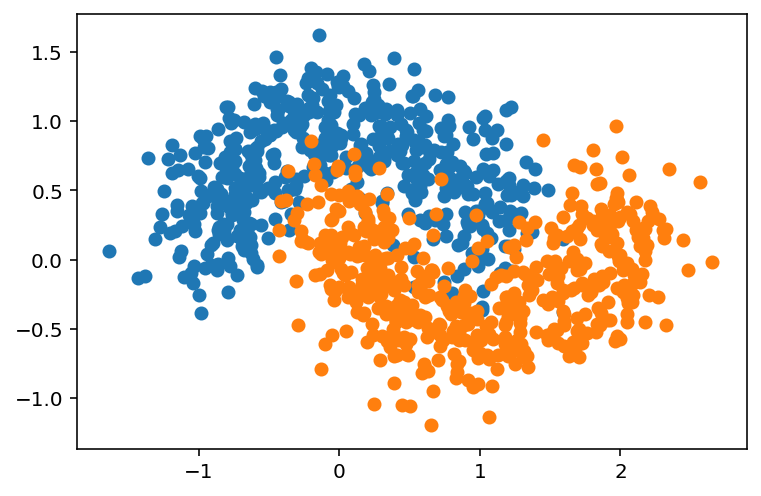

In [3]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

## Voting
采用多个模型，综合得到结果

- hard 少数服从大数
- soft 概率的平均数(但只适用于概率模型)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (750, 2)
y_train shape:  (750,)
X_test shape:  (250, 2)
y_test shape:  (250,)


In [5]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
log_clf.score(X_test, y_test)

0.808

In [6]:
# SVC
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train, y_train)
svc_clf.score(X_test, y_test)

0.928

In [7]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

dec_clf = DecisionTreeClassifier(random_state=666)
dec_clf.fit(X_train, y_train)
dec_clf.score(X_test, y_test)

0.904

### Hard
少数服从多数。多个模型里，选取数量最多的类别。

In [8]:
# 手动实现。
from sklearn.metrics import accuracy_score

y_predict1 = log_clf.predict(X_test)
y_predict2 = svc_clf.predict(X_test)
y_predict3 = dec_clf.predict(X_test)

y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')
accuracy_score(y_test, y_predict)

0.912

In [9]:
# 使用voting classifier.
from sklearn.ensemble import VotingClassifier

vot_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svc_clf', SVC()),
    ('dec_clf', DecisionTreeClassifier(random_state=666)),
], voting='hard')
vot_clf.fit(X_train, y_train)
vot_clf.score(X_test, y_test)

0.912

### soft
每个模型各个类别的概率的平局值，看谁大。eg: 

- 模型1 A-99%; B-1%
- 模型2 A-49%; B-51%
- 模型3 A-40%; B-60%
- 模型4 A-90%; B-10%
- 模型5 A-30%; B-70%

A = (0.99 + 0.49 + 0.4 + 0.9 + 0.3) / 5 = 0.616
B = (0.01 + 0.51 + 0.6 + 0.1 + 0.7) / 5 = 0.384

A > B 所以选择A


In [10]:
# 使用voting classifier. svc probability=True 概率
from sklearn.ensemble import VotingClassifier

vot_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svc_clf', SVC(probability=True)),
    ('dec_clf', DecisionTreeClassifier(random_state=666)),
], voting='soft')
vot_clf.fit(X_train, y_train)
vot_clf.score(X_test, y_test)

0.916

## Bagging & Pasting
基于样本随机取样。因为有很多小样本，之间是独立的，所以特别适合并发运算,可以设置job数。

- Bagging: 放回采样
- Pasting: 不放回采样

### Bagging

集成的子模型一般使用决策树(其实也就是随机森林)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# n_estimators 抽样次数；max_samples 每次抽样额样本数
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100, max_samples=100, bootstrap=True)

bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.896

In [12]:
# 提高 n_estimators 500->5000
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=5000, max_samples=100, bootstrap=True)

bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.9

#### 使用oob
因为Bagging是放回取样，根据调查，平均约有37%的样本取不到。所以可以开启oob(oob_score=True),将没取到的样本用于测试数据集，这样就可以不用在开始划分出数据集。

In [13]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100, bootstrap=True, oob_score=True)

bagging_clf.fit(X_train, y_train)
bagging_clf.oob_score_

0.9386666666666666

### bootstrap_features
基于特征随机取样

- Random Subspaces: 特征随机取样
- Random Patches: 样本+特征随机取样

In [14]:
# Random Subspaces  bootstrap_features=True, max_features=1 
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=750, bootstrap=True, oob_score=True,
                                bootstrap_features=True, max_features=1)

bagging_clf.fit(X_train, y_train)
bagging_clf.oob_score_

0.8626666666666667

In [15]:
# Random Patches
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100, bootstrap=True, oob_score=True,
                                bootstrap_features=True, max_features=1)

bagging_clf.fit(X_train, y_train)
bagging_clf.oob_score_

0.9133333333333333

###  Pasting
TODO: 待补充

## 随机森林 & Extra-Trees

### 随机森林
随机森林拥有决策树和BaggingClassifier所有参数

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=666)
rf_clf.fit(X, y)
rf_clf.oob_score_

0.925

### Extra-Trees
决策树在节点划分上，使用随机的特征和随机的阀值提供额外的随机性，抑制过拟合，但增大了bias更快的训练速度

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, bootstrap=True, oob_score=True, random_state=666)
et_clf.fit(X, y)
et_clf.oob_score_

0.925

## Boosting
集成多个模型，每个模型都在尝试增强(Boosting)整体效果

### AdaBoosting

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=500, random_state=666)
ada_clf.fit(X_train, y_train)
ada_clf.score(X_test, y_test)

0.9

### Gradient Boosting

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=500, random_state=666)
gb_clf.fit(X_train, y_train)
gb_clf.score(X_test, y_test)

0.892